# Imports

In [1]:
import numpy as np

In [2]:
from scipy.constants import physical_constants

In [3]:
import h5py
import os

In [4]:
from opmd_viewer import OpenPMDTimeSeries
from opmd_viewer.addons import LpaDiagnostics

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from matplotlib.animation import FuncAnimation

In [6]:
from IPython.display import HTML

# Paths

In [7]:
base_dir = '.'
out_dir = 'diags'
h5_dir = 'hdf5'

In [8]:
h5_path = os.path.join(base_dir, out_dir, h5_dir)

In [9]:
timestep = 78100 # 100
f_name = os.path.join(h5_path, 'data{:08d}.h5'.format(timestep))
f = h5py.File(f_name, 'r')
fields = '/data/{}/fields'.format(timestep)
handler = f[fields]

In [10]:
f_name

'./diags/hdf5/data00078100.h5'

In [11]:
bpath = f['/data/{}'.format(timestep)]

In [12]:
t = bpath.attrs["time"] * bpath.attrs["timeUnitSI"]

In [13]:
t * 1e15 # time in fs

8336.4338671922178

In [14]:
dt = bpath.attrs["dt"] * bpath.attrs["timeUnitSI"] * 1e15 # time step in fs
print('dt = {:05.3f} fs.'.format(dt))

dt = 0.107 fs.


In [15]:
t * 1e15 - timestep * dt # 0.0

0.0

In [16]:
max_iterations = 78100

# Density

In [17]:
m_e = physical_constants['electron mass']

In [18]:
n_e = 7.5e18 * 1e6 # initial electron density in m^{-3}
q_e = physical_constants['elementary charge'][0] # electron charge in C
m_e = physical_constants['electron mass'][0] # electon mass in Kg

rho = handler['rho']
unit_factor = rho.attrs['unitSI'] / (-q_e * n_e)
print('unit_factor = {} m^3/C'.format(unit_factor))

unit_factor = -8.322012167844344e-07 m^3/C


In [19]:
c = physical_constants['speed of light in vacuum'][0] # speed of light in m/s
mc2 = m_e * c**2 / (q_e * 1e6) # electron rest energy in MeV: 0.511
print('mc**2 = {:05.3f} MeV.'.format(mc2))

c = c * 1e-9 # speed of light in mu/fs
print('c = {:05.3f} mu/fs.'.format(c))

tstep_to_pos = c * dt # conversion factor in mu

mc**2 = 0.511 MeV.
c = 0.300 mu/fs.


In [20]:
ts_circ = OpenPMDTimeSeries(h5_path)#, check_all_files=False)

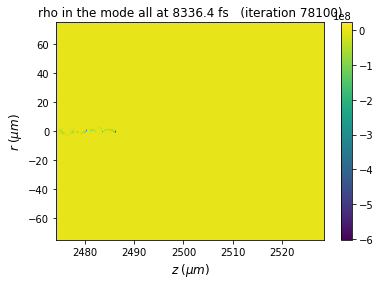

In [21]:
# density in C/m^3
rho, info_rho = ts_circ.get_field(field='rho', iteration=timestep, m='all',
                                 plot=True)

In [22]:
print('dr = {:05.3f} mu; dz = {:05.3f} mu.'.format(info_rho.dr*1e6, info_rho.dz*1e6))

dr = 0.259 mu; dz = 0.032 mu.


## Animation

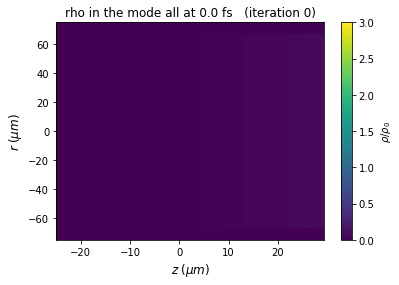

In [23]:
F, info = ts_circ.get_field(field='rho', iteration=0, m='all')

fig, ax = plt.subplots() # figsize=(10, 6)
# Get the title and labels
ax.set_title("%s in the mode %s at %.1f fs   (iteration %d)"
          % ('rho', 'all', 0, 0),
          fontsize=12)

# Add the name of the axes
ax.set_xlabel('$%s \;(\mu m)$' % info.axes[1], fontsize=12)
ax.set_ylabel('$%s \;(\mu m)$' % info.axes[0], fontsize=12)

ax.set_ylim(info.rmin*1e6, info.rmax*1e6)

# Plot the data
img_opts = {'origin' : 'lower', 'interpolation' : 'nearest', 'aspect' : 'auto',
            'vmin' : 0, 'vmax' : 3}
img = ax.imshow(F * unit_factor, extent=1.e6 * info.imshow_extent, **img_opts)
cbar = fig.colorbar(img)
cbar.set_label(r'$\rho/\rho_0$')

In [24]:
def animate(i):
    time_fs = i * dt
    F, info = ts_circ.get_field(field='rho', iteration=i, m='all')
    
    ax.collections = []
    ax.imshow(F * unit_factor, extent=1.e6 * info.imshow_extent, **img_opts)
    
    ax.set_xlim(info.zmin*1e6, info.zmax*1e6)
    ax.set_title("%s in the mode %s at %.1f fs   (iteration %d)"
          % ('rho', 'all', time_fs, i),
          fontsize=12)

In [25]:
anim = FuncAnimation(
    fig, animate, interval=100, frames=range(0, max_iterations, 100))

In [26]:
anim.save('lwfa.gif', writer='imagemagick', fps=10)

In [27]:
HTML('<img src="lwfa.gif">')

# Laser diagnostics

In [28]:
ts_2d = LpaDiagnostics(h5_path, check_all_files=False)

In [29]:
def get_laser_diags(ts, t=None, iteration=None, pol='x', m='all',
                    method='fit', prnt=False, units='SI'):
    """
    Calculate the centroid, main frequency, a0 value, 
    beam waist and pulse length of a Gaussian laser.
    
    Parameters
    ----------
    ts : LpaDiagnostics time series instance
        An instance of the LpaDiagnostics class
    t : float (in seconds), optional
        Time at which to obtain the data (if this does not correspond to
        an available file, the last file before `t` will be used)
        Either `t` or `iteration` should be given by the user.
    iteration : int
        The iteration at which to obtain the data
        Either `t` or `iteration` should be given by the user.
    pol : string
        Polarization of the field. Options are 'x', 'y'
    m : int or str, optional
        Only used for thetaMode geometry
        Either 'all' (for the sum of all modes) 
        or an integer (for the selectrion of a particular mode)
    method : str, optional
       The method which is used to compute the waist,
       both longitudinal and transverse
       'fit': Gaussian fit of the profile
       'rms': RMS radius, weighted by the profile
       ('rms' tends to give more weight to the "wings" of the pulse)
    prnt : bool
        Weather to print the values out
    units : str
        The unit system used, either
        'SI' : rads, meters, seconds
        'mufs' : rads, microns, femtoseconds
    
    Returns
    -------
    A tuple with:
    z0 : float
        Centroid of the laser in meters
    omega0 : float
        Mean angular frequency in rad/s
    a0 : float
        Normalized vector potential
    w0 : float
        Beam waist in meters
    ctau : float
        Pulse length (longitudinal waist) in meters
    """
    if pol not in ['x', 'y']:
        raise ValueError('The `pol` argument is missing or erroneous.')

    if pol == 'x':
        slicing_dir = 'y'
        theta = 0
    else:
        slicing_dir = 'x'
        theta = np.pi / 2.
    
    # get pulse envelope
    E_vs_z, info = ts.get_laser_envelope(t=t, iteration=iteration,
                                         pol=pol, m=m, theta=theta,
                                         slicing_dir=slicing_dir,
                                         index='center')
    i_max = np.argmax( E_vs_z )
    z0 = info.z[i_max]
    omega0 = ts.get_main_frequency(t=t, iteration=iteration, pol=pol)
    a0 = ts.get_a0(t=t, iteration=iteration, pol=pol)
    w0 = ts.get_laser_waist(t=t, iteration=iteration, pol=pol, theta=theta,
                         slicing_dir=slicing_dir, method=method)
    ctau = ts.get_ctau(t=t, iteration=iteration, pol=pol, method=method)

    # assign units
    z0_u, omega0_u, w0_u, ctau_u = 'm', 'rad/s', 'm', 'm'

    if units=='mufs':
        # rescale
        z0, omega0, w0, ctau = z0*1e6, omega0*1e-15, w0*1e6, ctau*1e6
        # change units
        z0_u, omega0_u, w0_u, ctau_u = 'mu', 'rad/fs', 'mu', 'mu'
        
    if prnt and units=='mufs':
        print('z0={:06.2f} {}, omega0={:06.2f} {}, a0={:06.2f}, w0={:06.2f} {}, ctau={:06.2f} {}.'.format(z0, z0_u, omega0, omega0_u, a0, w0, w0_u, ctau, ctau_u))
    return z0, omega0, a0, w0, ctau

In [30]:
tstep_v = np.arange(0, max_iterations, 100)

z0_v = np.zeros_like(tstep_v, dtype=np.float32)
omega0_v = np.zeros_like(tstep_v, dtype=np.float32)
a0_v = np.zeros_like(tstep_v, dtype=np.float32)
w0_v = np.zeros_like(tstep_v, dtype=np.float32)
ctau_v = np.zeros_like(tstep_v, dtype=np.float32)

In [31]:
for i, tstep in enumerate(tstep_v):
    z0_v[i], omega0_v[i], a0_v[i], w0_v[i], ctau_v[i] = \
    get_laser_diags(ts_2d, iteration=tstep, units='mufs')

/home/andrei/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


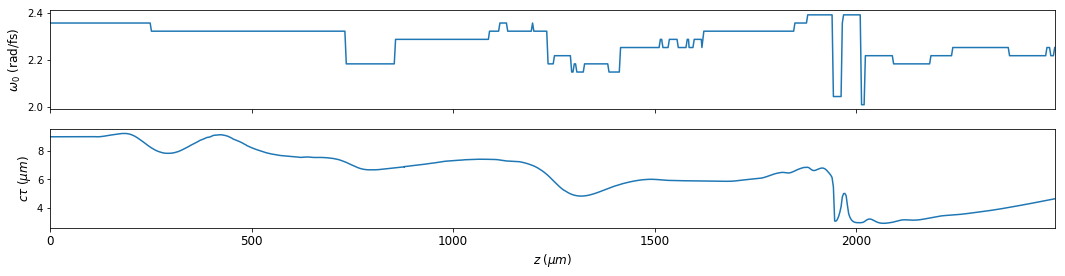

In [32]:
fig = plt.figure(figsize=(18, 4))
ax1 = plt.subplot(211)
plt.plot(z0_v, omega0_v)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('$%s$ (rad/fs)' % '\omega_0', fontsize=12)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(z0_v, ctau_v)
plt.setp(ax2.get_xticklabels(), fontsize=12);
ax2.set_xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
ax2.set_ylabel(r'$c \tau \;(\mu m)$', fontsize=12)

plt.xlim(z0_v[0], z0_v[-1]);

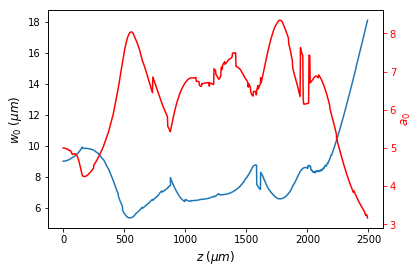

In [33]:
plt.plot(z0_v, w0_v)
#plt.ylim(0,40)
plt.ylabel('$%s \;(\mu m)$' % 'w_0', fontsize=12)
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
plt.twinx()
plt.plot(z0_v, a0_v, color='red')
plt.ylabel('$%s$' % 'a_0', fontsize=12, color='r')
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
plt.tick_params('y', colors='r')

In [34]:
# Parameters from the histograms
nbins = 100 # Number of bins
Emin = 1. # MeV
Emax = 300. # MeV

iterations = ts_2d.iterations[ts_2d.iterations < max_iterations]

In [35]:
Q_bins = np.zeros( (iterations.size, nbins) )
E_bins = np.linspace( Emin, Emax, nbins+1 )
dE = (Emax - Emin)/nbins
print('dE = {}'.format(dE))

dE = 2.99


In [36]:
for i, tstep in enumerate(iterations):
    ux, uy, uz, w = ts_2d.get_particle(
       ['ux', 'uy', 'uz', 'w'], iteration=tstep )

    E = mc2 * np.sqrt( 1 + ux**2 + uy**2 + uz**2 )  # Energy in MeV
    Q_bins[i, :], _ = np.histogram( E, E_bins, weights = q_e * 1e12 / dE * w )  # weights in pC/MeV

In [37]:
z_min = iterations[0] * tstep_to_pos + 25 # mu
z_max = iterations[-1] * tstep_to_pos + 25 # offset by 25 because left margin is at -25

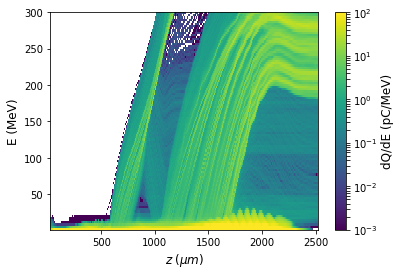

In [38]:
plt.imshow( Q_bins.T, origin='lower',
          extent=[z_min, z_max, Emin, Emax], aspect='auto',
          norm=LogNorm(), vmin=1e-3 , vmax=1e2)
plt.ylabel('E (MeV)', fontsize=12)
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
cb = plt.colorbar()
cb.set_label('dQ/dE (pC/MeV)', fontsize=12)